In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np 
import pandas as pd

kmax = 1000
lamb = 0.3
rho = 1/4
vax_rate = .40

I0 = 0.01 #initial fraction of infected nodes

# Initial conditions

pk_arr = np.array([rho*(1-rho)**k for k in range(1, kmax + 1)]) ## probability for each k

IVk = pk_arr*(vax_rate)*(I0) ## initial condition for infected vaccinated
IUk = pk_arr*(1-vax_rate)*(I0) ## initial condnition for infectedu unvaccinated

full_initial_c = np.concatenate([IVk, IUk]) ## all initial conditions together (to prepare for integator)

In [2]:
def decompose_full_arr(arr, kmax):
    IVk = arr[0:kmax]
    IUk = arr[kmax:(kmax*2)]

    return IVk, IUk

def SIS_net(w, t, p):
    ## initial followed this example to build this model https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html
    lamb, vax_rate, rho, kmax = p

    ks = np.arange(1, kmax+1)
    pk = np.array([rho*(1-rho)**k for k in range(1, kmax + 1)])
    
    IVk, IUk = decompose_full_arr(w, kmax)

    theta = ((1-rho)*sum(IVk*ks) + sum(IUk*ks))/sum(ks*pk)

    IVk_dt = lamb*theta*ks*(1-rho)*(vax_rate*pk - IVk) - IVk
    IUk_dt = lamb*theta*ks*((1-vax_rate)*pk - IUk) - IUk

    full_status = np.concatenate([IVk_dt, IUk_dt])
    
    return full_status

def run_integrator(initial_I, rho, numpoints, stoptime = 10.0, abserr = 1.0e-8, relerr = 1.0e-6):
    p = [lamb, vax_rate, rho, kmax]
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    wsol = odeint(SIS_net, initial_I, t, args=(p,))
    result_list =  [tuple(decompose_full_arr(ts, kmax)) for ts in (wsol.tolist())]
    infected_ts = [sum(obs[0]) + sum(obs[1]) for obs in result_list]
    return pd.DataFrame.from_dict({"rho": rho, "ts": np.arange(0, numpoints),  "infected": infected_ts})


In [3]:
rho_test = np.arange(.05, .95, .05)
rho_simulation_result = [run_integrator(full_initial_c, rho, 5000) for rho in rho_test  ]
rho_result_pd = pd.concat(rho_simulation_result)

In [12]:
rho_result_pd.query("infected < .0001").sort_values(["rho", "ts"]) ## first moment and lowest rho where infected breaches threshold

,rho,ts,infected,part
4918,0.55,4918,0.000100,c
4919,0.55,4919,0.000100,c
4920,0.55,4920,0.000100,c
4921,0.55,4921,0.000100,c
4922,0.55,4922,0.000100,c
...,...,...,...,...
4995,0.90,4995,0.000005,c
4996,0.90,4996,0.000005,c
4997,0.90,4997,0.000005,c
4998,0.90,4998,0.000005,c


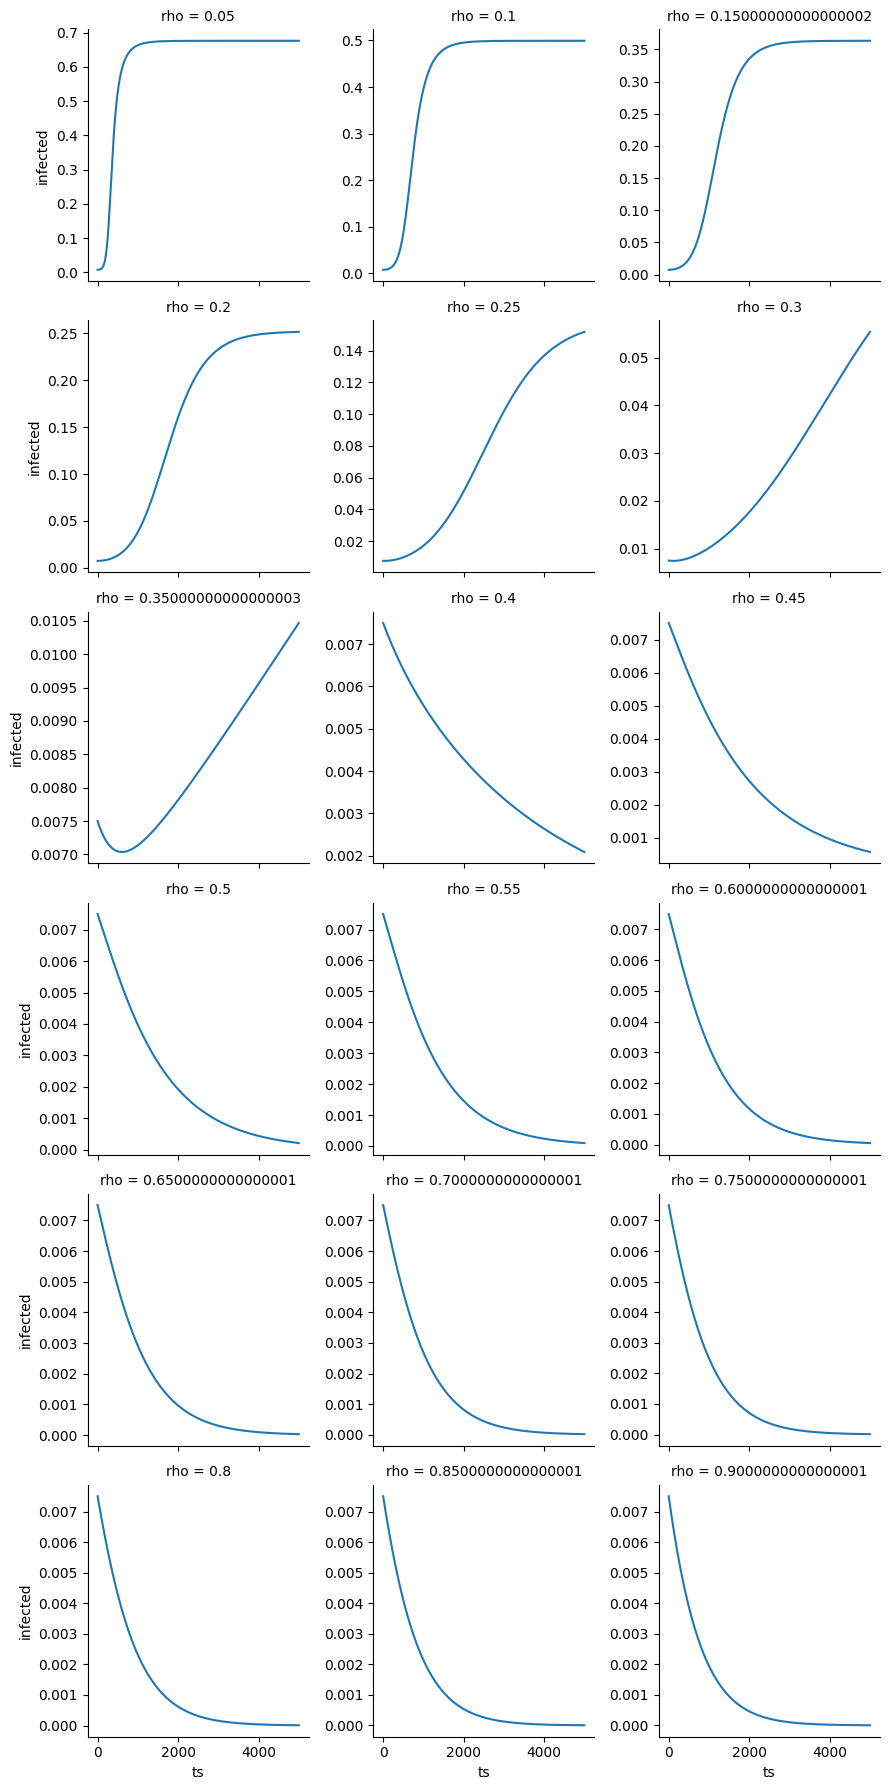

In [4]:
import seaborn as sns

g = sns.FacetGrid(rho_result_pd, col = "rho", col_wrap = 3, sharey = False)
g.map_dataframe(sns.lineplot, x = "ts", y = "infected")

g.savefig("03/output/c_infection_curve.png")


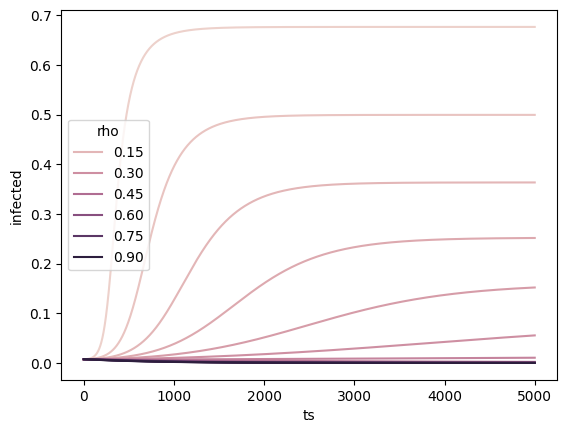

In [5]:
# plot again, but all graphs in the same plot
c_all = sns.lineplot(data = rho_result_pd, x = "ts", y = "infected", hue = "rho")

fig = c_all.get_figure()
fig.savefig("03/output/c_infection_curve_all.png")

In [19]:
vax_d = np.zeros(kmax)
vax_d[(int(kmax*.40)):kmax] = pk_arr[(int(kmax*.40)):kmax]*vax_rate

unvax_d = np.zeros(kmax)
unvax_d[0:(int(kmax*.40))] = pk_arr[0:(int(kmax*.40))]

IVk_d = vax_d*(I0) 
IUk_d = unvax_d*(I0)

full_initial_d = np.concatenate([IVk_d, IUk_d])

In [7]:
rho_simulation_result_d = [run_integrator(full_initial_d, rho, 5000) for rho in rho_test  ]
rho_result_d_pd = pd.concat(rho_simulation_result_d)

In [8]:
rho_result_d_pd["part"] = "d"
rho_result_pd["part"] = "c"
all_rho_results = pd.concat([rho_result_d_pd, rho_result_pd])

In [13]:
all_rho_results.query("infected < .0001 and part == 'd'").sort_values(["rho", "ts"]) ## first moment where part d breaches threshold (lowest rho)

,rho,ts,infected,part
4546,0.6,4546,0.000100,d
4547,0.6,4547,0.000100,d
4548,0.6,4548,0.000100,d
4549,0.6,4549,0.000100,d
4550,0.6,4550,0.000099,d
...,...,...,...,...
4995,0.9,4995,0.000007,d
4996,0.9,4996,0.000007,d
4997,0.9,4997,0.000007,d
4998,0.9,4998,0.000007,d


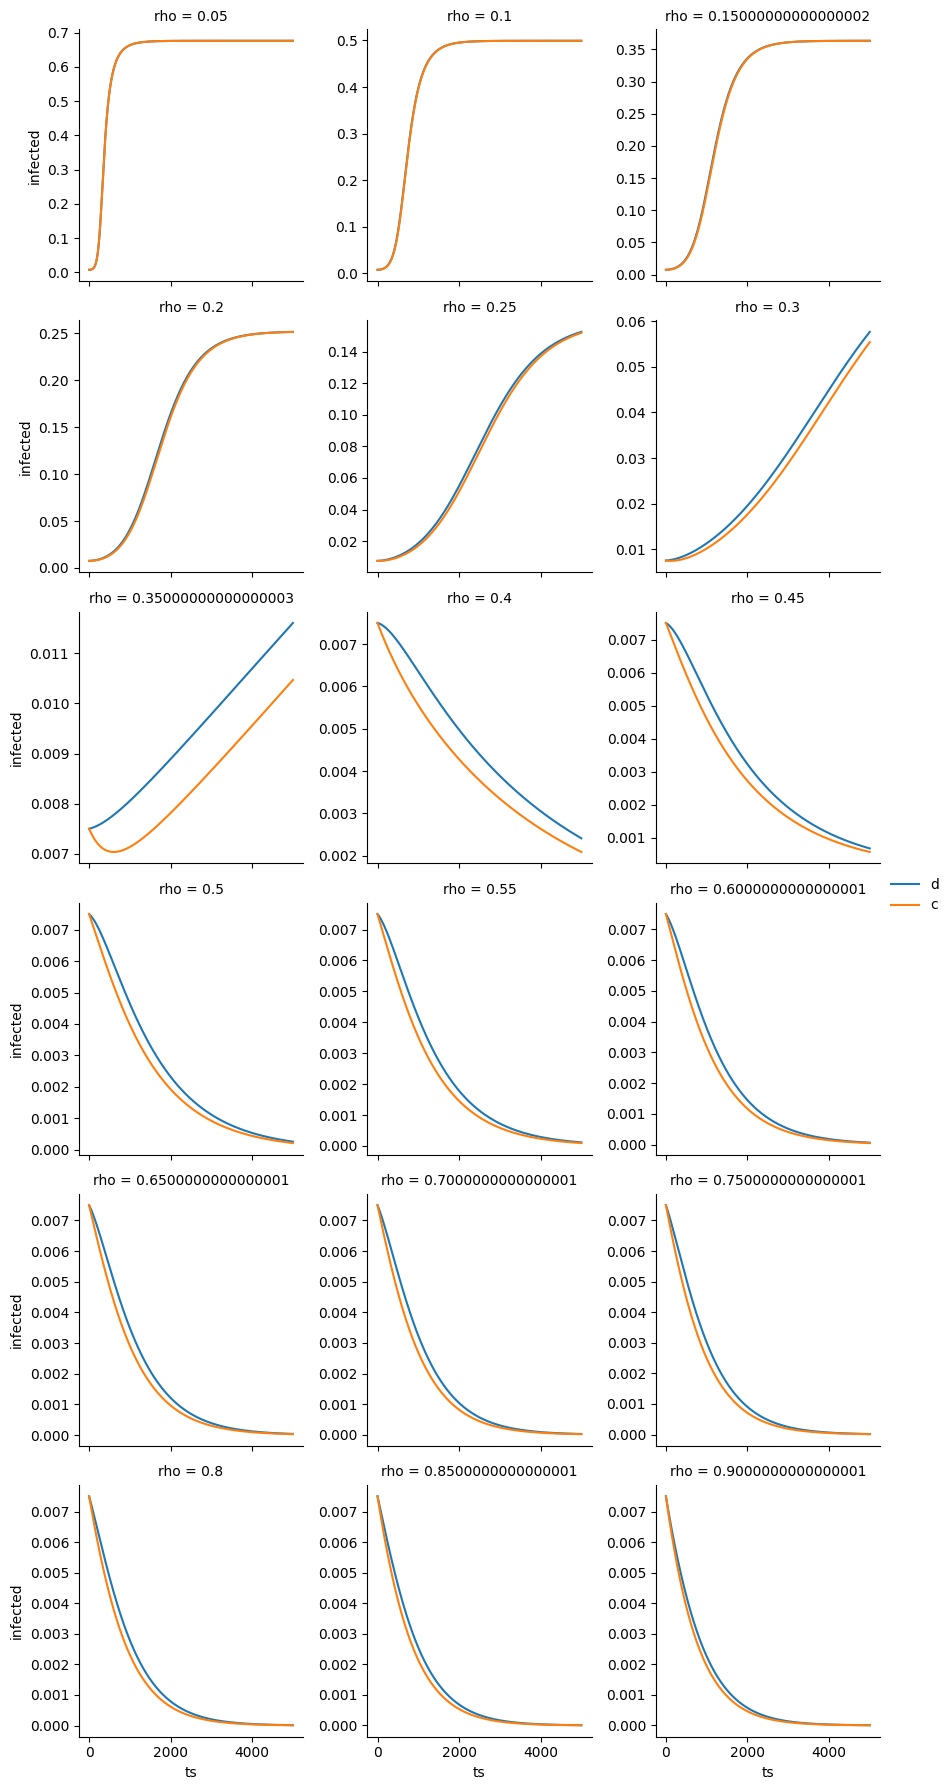

In [9]:
g = sns.FacetGrid(all_rho_results, col = "rho", col_wrap = 3, sharey = False)
g.map_dataframe(sns.lineplot, x = "ts", y = "infected", hue = "part")
g.add_legend()

g.savefig("03/output/c_d_infection_curve.png")


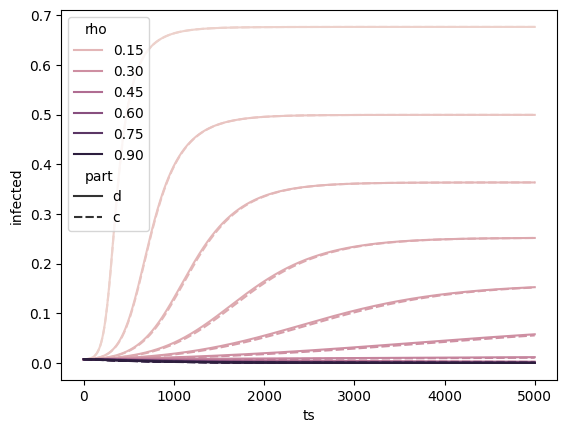

In [10]:

# plot again but all graphs in one plot
c_d_all = sns.lineplot(data = all_rho_results, x = "ts", y = "infected", hue = "rho", style = "part")

fig = c_d_all.get_figure()
fig.savefig("03/output/c_d_infection_curve_all.png")